# Table of Contents

MOI = Morisita's overlap index

The use of the word "child" is being used interchangeably to mean "the anne subcorpus of Manchester" and "the CHI speaker in the anne subcorpus of Manchester". This can be confusing sometimes.

## [Per-session Child-Adult MOI](#basic-morisita)

Unigram, bigram, trigram per-session MOI between child and adult. 

We look at each Manchester subcorpus individually and see how the MOI between the child and adult changes over time, and then aggregate these observations.

## [Per-session Child-Adult MOI on common ngrams](#zero-count-ngrams)
The same analysis as above, but ngrams that were not shared between child and adult during a single session are dropped from the MOI of that session.

In computing the MOI for session 4 between Anne and her mother, the only ngrams used will be those produced by *both* Anne and her mother during session 4.

## [Adult-Adult MOI](#adult-adult-moi)

Similar to the above analysis but we simulate adult-adult conversations by pairing up the adults in the Manchester corpus in every possible combination.

"Pretend Anne's mom and Aran's mom were talking to each other for all 34 sessions instead of their children. How does their MOI vary over time?"

## [Child-Child MOI](#child-child-moi)

Same analysis as above but simulating conversation between pairings of children.

## [Child-Child MOI on common ngrams](#child-child-moi-common-within-session)

Same as above but only running MOI on the ngrams common to two children during a session.

In computing the MOI for session 4 between Anne and Aran, the only ngrams used will be those produced by *both* Anne and Aran during session 4.

## Per-Child plots
A single plot for each Manchester child's per-session child-adult MOI.
- [Per-Child Unigrams Plots](#per-child-unigram)
- [Per-Child Bigram Plots](#per-child-bigram)
- [Per-Child Trigram Plots](#per-child-trigram)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_manchester

def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)

def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    plt.ylabel("Morisita's Overlap Index")
    plt.show()

# Quick Test 

Testing example from "Testing for Significance of Morisita's, Horn's and Related Measures of Overlap"

The morisita calculation for X and Y should be 0.83

In [2]:
x = pd.Series([.2, .3, .5])
y = pd.Series([.1, .6, .3])
morisita(x, y)

0.83333333333333326

# Load Dataset

In [3]:
unigrams, bigrams, trigrams = get_manchester("/home/paul/corpora/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

<a id='basic-morisita'></a>
# Basic Child-Adult Morisita comparison

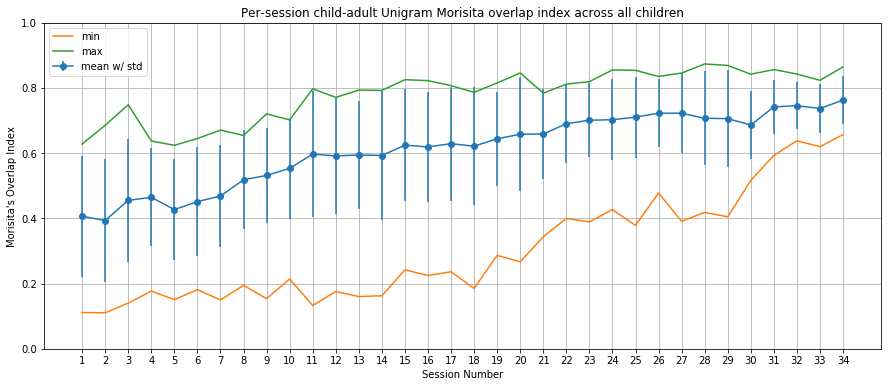

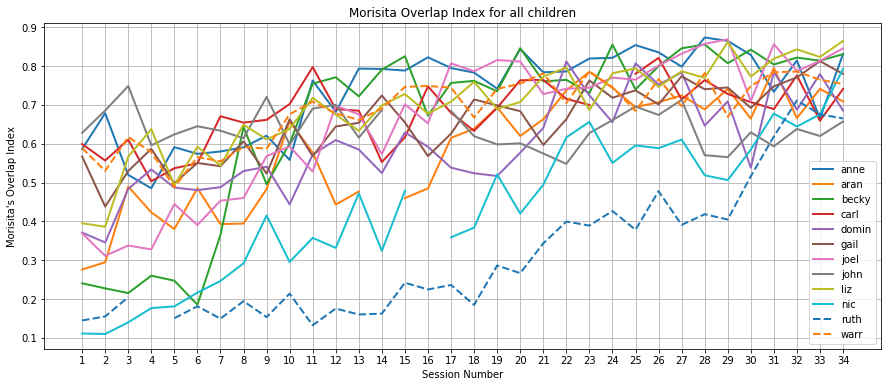

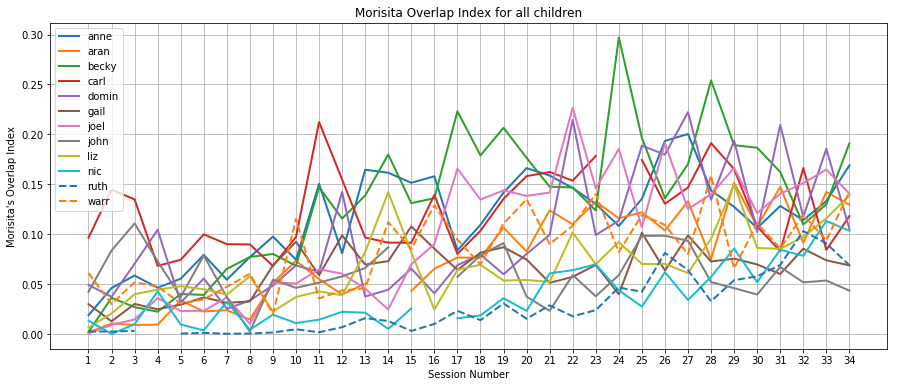

In [4]:
plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend();
    per_session_plot('Morisita Overlap Index for all children')

for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Per-session child-adult {} Morisita overlap index across all children'.format(name.capitalize()))
    plot_all_children_together(dataset, name)

<a id='zero-count-ngrams'></a>
# Child-Adult MOI - within-session common ngrams only

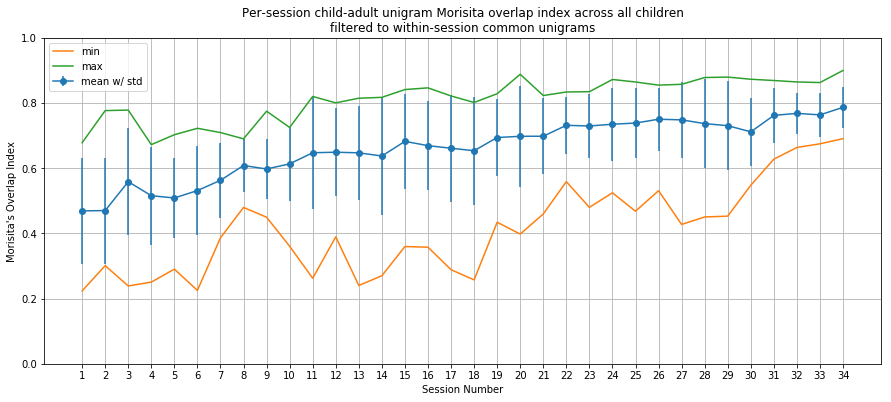

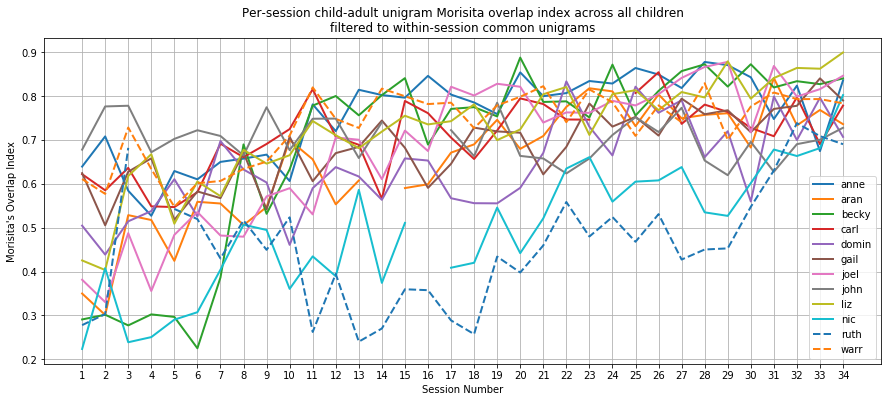

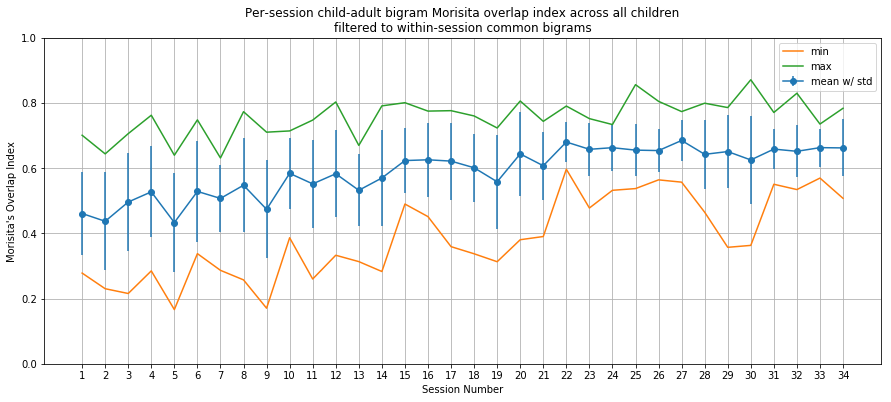

In [5]:
plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult, drop_zeros=True)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend()
    per_session_plot(('Per-session child-adult {0} Morisita overlap index across all children\n'
                      'filtered to within-session common {0}s').format(name))
    
for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult, drop_zeros=True)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(('Per-session child-adult {0} Morisita overlap index across all children\n'
                      'filtered to within-session common {0}s').format(name))
    plot_all_children_together(dataset, name)

<a id='adult-adult-moi'></a>
# Adult-Adult Comparisons

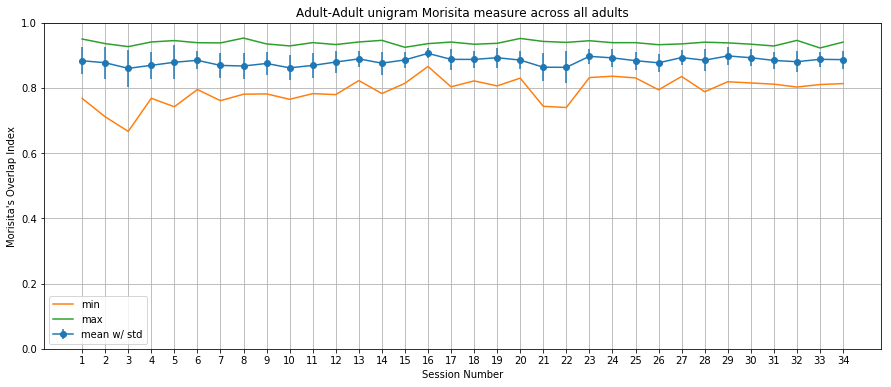

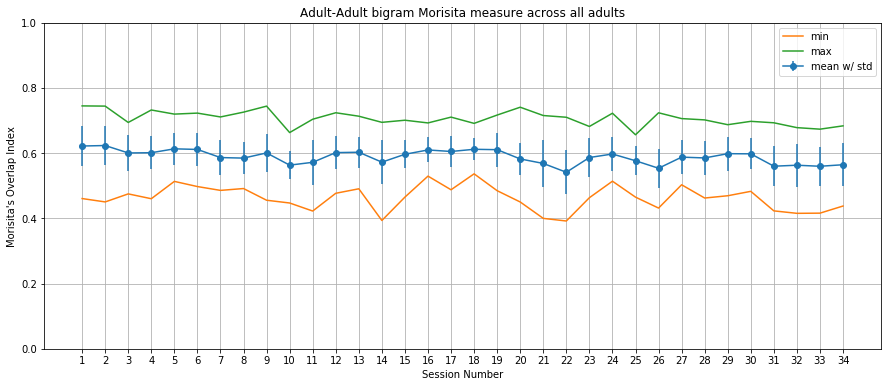

In [6]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset[dataset.speaker.eq('MOT')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        dataset.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        dataset.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Adult-Adult {} Morisita measure across all adults'.format(name))

<a id='child-child-moi'></a>
# Child-Child Comparison

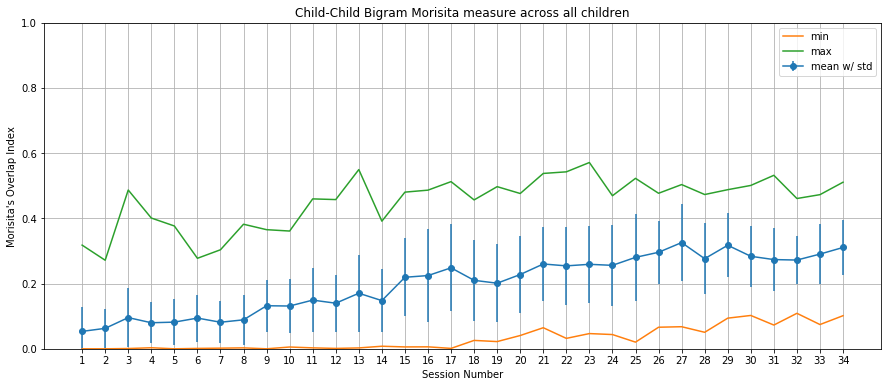

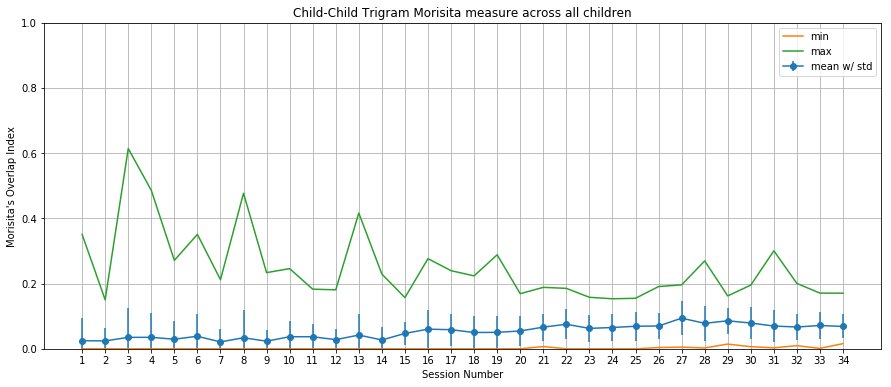

In [7]:
from itertools import combinations

def normalized_counts(series):
    counts = series.value_counts()
    return counts / counts.sum()


for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset[dataset.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        dataset.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        dataset.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts)))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Child-Child {} Morisita measure across all children'.format(name.capitalize()))

<a id='child-child-moi-common-within-session'></a>
# Child-Child Comparison on common ngrams

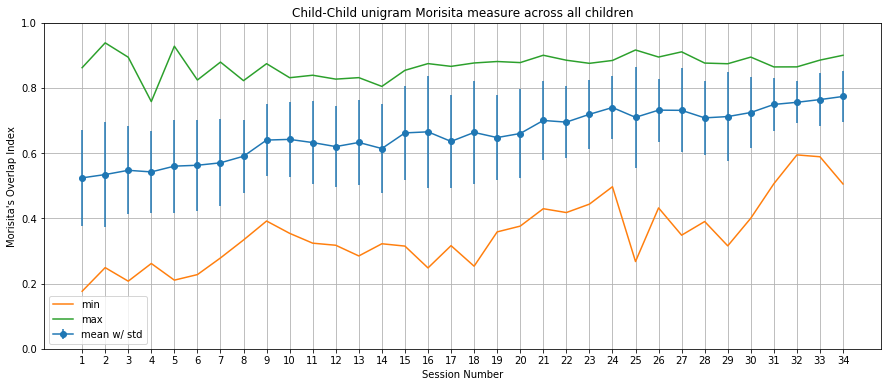

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


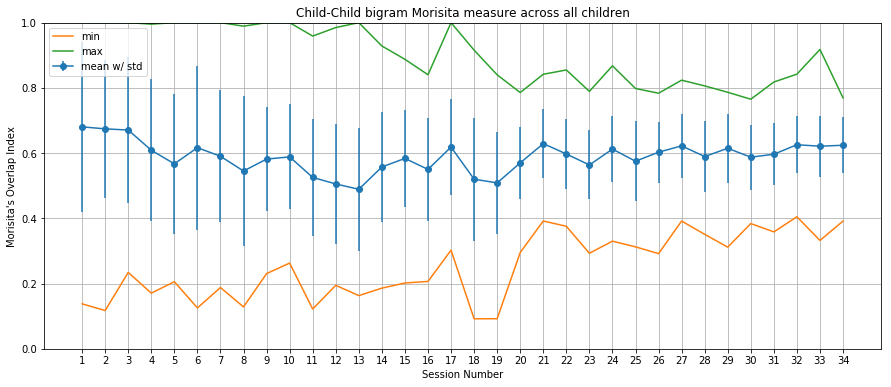

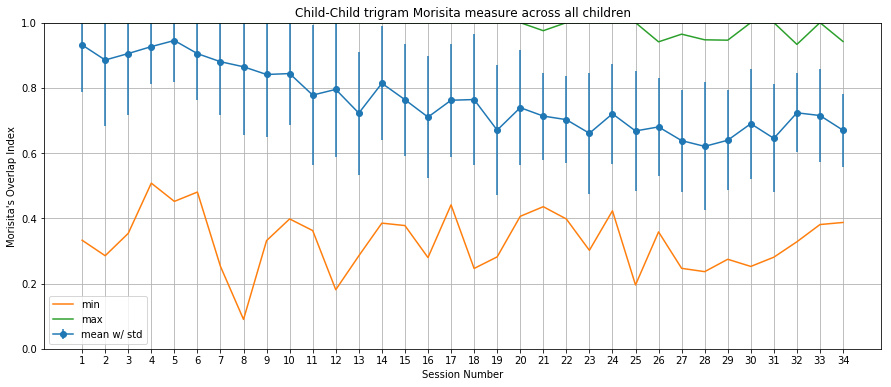

In [9]:
for dataset, name in zip([unigrams, bigrams, trigrams], ['unigram', 'bigram', 'trigram']):
    groups = dataset[dataset.speaker.eq('CHI')].groupby(['corpus', 'session']).groups

    adult_adult = [(session1, corpus1, corpus2, morisita(
        dataset.loc[groups[(corpus1, session1)]].ngram.pipe(normalized_counts),
        dataset.loc[groups[(corpus2, session2)]].ngram.pipe(normalized_counts),
                   drop_zeros=True))
        for (corpus1, session1), (corpus2, session2) in combinations(groups.keys(), 2) 
        if (session1 == session2 and corpus1 != corpus2)]

    adult_adult_df = pd.DataFrame(adult_adult, columns='session corpus_a corpus_b score'.split())
    stats = (
        adult_adult_df
        .groupby('session')
        .score
        .describe()
    )
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot('Child-Child {} Morisita measure across all children'.format(name))

# Child-adult Morisita with cumulative child vocabulary

In [132]:
def shared_vocab(child_corpus, adult_corpus):
    "Computes the ngrams shared between the two speakers"
    return set(child_corpus.ngram.values) & set(adult_corpus.ngram.values)

def valid_ngram(ngram, shared_vocab): 
    "Returns true if the string `ngrams` only contains words from the shared vocab"
    for word in ngram.split(' '):
        if word not in shared_vocab:
            return False
    return True

# TODO: WTF is going on with nic 16 ??

def morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session):
    vocab_source = unigrams[unigrams.corpus.eq(corpus) & unigrams.session.lt(session + 1)]
    vocab = shared_vocab(vocab_source[vocab_source.speaker.eq('CHI')],
                         vocab_source[vocab_source.speaker.eq('MOT')])

    corpus_filter = dataset.corpus.eq(corpus)
    session_filter = dataset.session.eq(session)

    target_utts = dataset[corpus_filter & session_filter]
    child = target_utts[target_utts.speaker.eq('CHI')]
    adult = target_utts[target_utts.speaker.eq('MOT')]

    num_adult_utts = len(adult)
    adult = adult[adult.ngram.apply(lambda ngram: valid_ngram(ngram, vocab))]
    
    if adult.empty:
        return {'morisita': np.nan,
                'corpus': corpus,
                'session': session,
                'discarded_utts': num_adult_utts - len(adult)}
    
    moi = morisita(child.ngram.value_counts(), 
                   adult.ngram.value_counts())
    
    return {'morisita': moi,
            'corpus': corpus,
            'session': session,
            'child_utts': len(child),
            'adult_utts': num_adult_utts,
            'filtered_adult_utts': len(adult)}

In [137]:
dataset=unigrams
shared_vocab_unigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

dataset=bigrams
shared_vocab_bigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

NameError: name 'trigram' is not defined

In [138]:
dataset=trigrams
shared_vocab_trigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

# Child-Adult Morisita controlled for cumulative child vocabulary

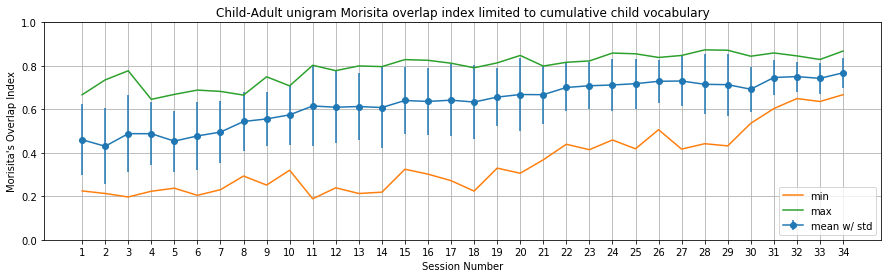

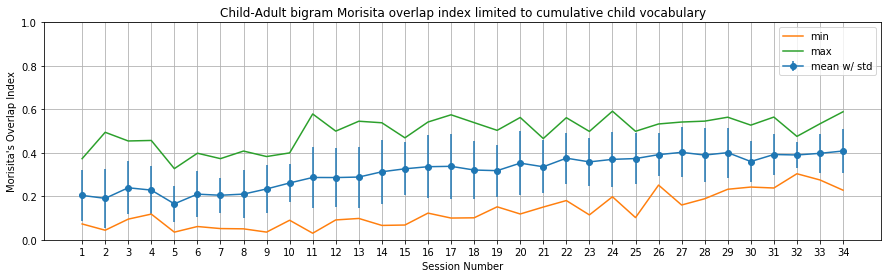

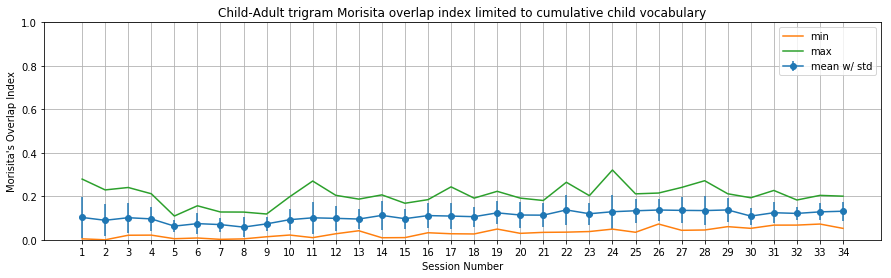

In [140]:
for result, name in zip([shared_vocab_unigrams, shared_vocab_bigrams, shared_vocab_trigrams],
                        ['unigram', 'bigram', 'trigram']):
    stats = result.groupby('session').morisita.describe()
    plt.ylim(0, 1)
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats['min'])
    plt.plot(stats['max'])
    per_session_plot('Child-Adult {} Morisita overlap index limited to cumulative child vocabulary'.format(name))
    
#     discarded = 1 - (result.filtered_adult_utts / result.adult_utts)
#     stats = result.groupby('session').morisita.describe()
#     plt.ylim(0, 1)
#     plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
#     plt.plot(stats['min'])
#     plt.plot(stats['max'])
#     per_session_plot('Child-Adult {} Morisita overlap index limited to cumulative child vocabulary')

In [ ]:
shared_vocab_bigrams

In [53]:
adult = bigrams[bigrams.corpus.eq('aran') & bigrams.speaker.eq('MOT')]

In [57]:
adult[adult.ngram.apply(lambda ngram: valid_ngram(ngram, {'the', 'best'}))]

index                                          filename   uid  \
159103  159103  /home/paul/Downloads/Manchester/aran/aran04a.xml  u485   
186961  186961  /home/paul/Downloads/Manchester/aran/aran09b.xml  u105   
196379  196379  /home/paul/Downloads/Manchester/aran/aran11a.xml  u234   
205148  205148  /home/paul/Downloads/Manchester/aran/aran12b.xml  u123   
311013  311013  /home/paul/Downloads/Manchester/aran/aran30a.xml  u299   
318406  318406  /home/paul/Downloads/Manchester/aran/aran31a.xml  u538   
318474  318474  /home/paul/Downloads/Manchester/aran/aran31a.xml  u556   
318569  318569  /home/paul/Downloads/Manchester/aran/aran31a.xml  u575   

       speaker     ngram corpus  session part  
159103     MOT  the best   aran        4    a  
186961     MOT   the the   aran        9    b  
196379     MOT   the the   aran       11    a  
205148     MOT  the best   aran       12    b  
311013     MOT  the best   aran       30    a  
318406     MOT  the best   aran       31    a  
318474     MOT  the best   aran       31    a  
318569     MOT  the best   aran       31    a

In [45]:
groups.keys()

dict_keys(['anne', 'aran', 'becky', 'carl', 'domin', 'gail', 'joel', 'john', 'liz', 'nic', 'ruth', 'warr'])

In [33]:
test = unigrams[unigrams.session.eq(2) & unigrams.corpus.eq('anne')]
s = shared_vocab(test[test.speaker.eq('CHI')], test[test.speaker.eq('MOT')])

<a id='per-child-unigram'></a>
# Per-child plots of Morisita Unigrams

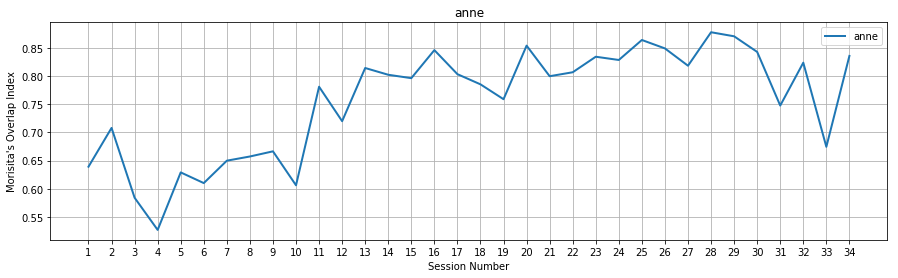

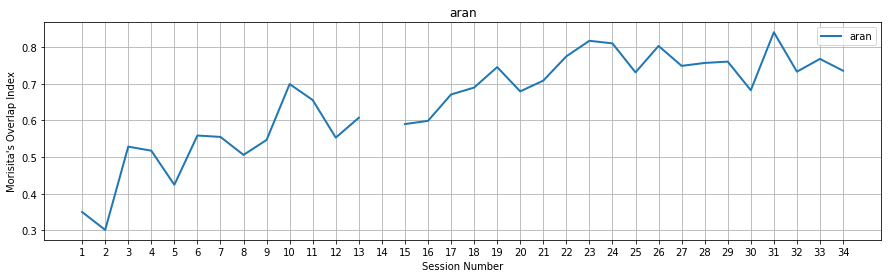

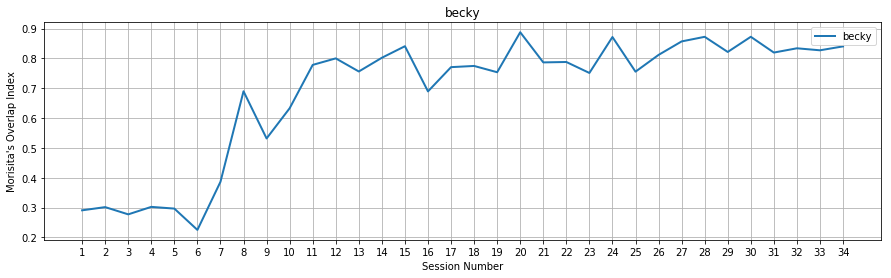

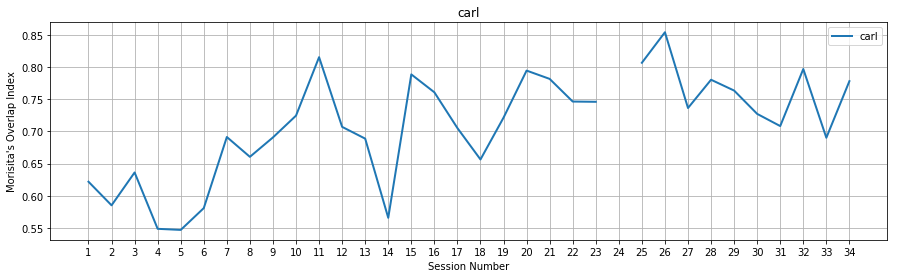

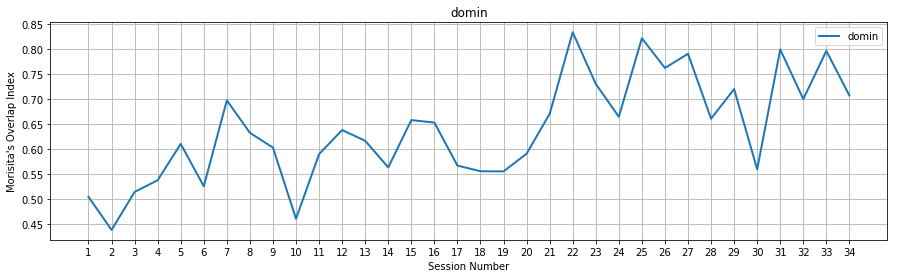

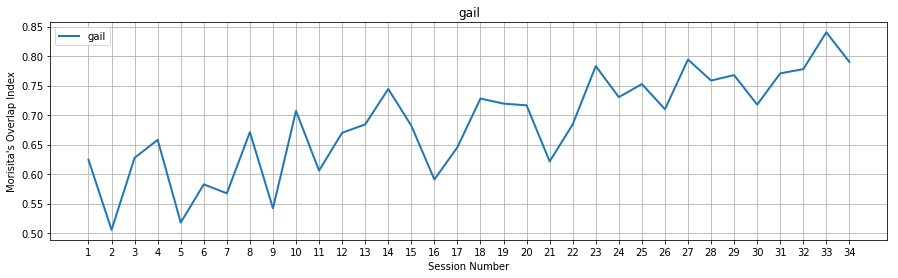

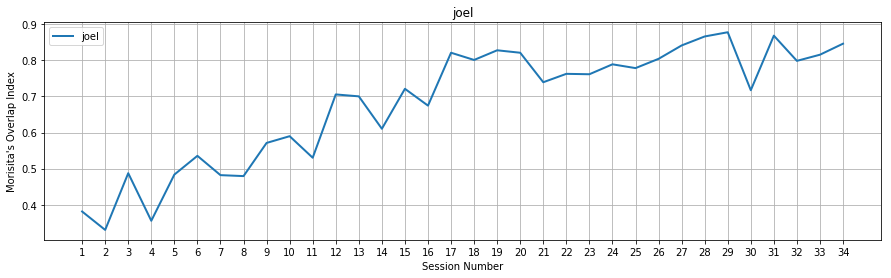

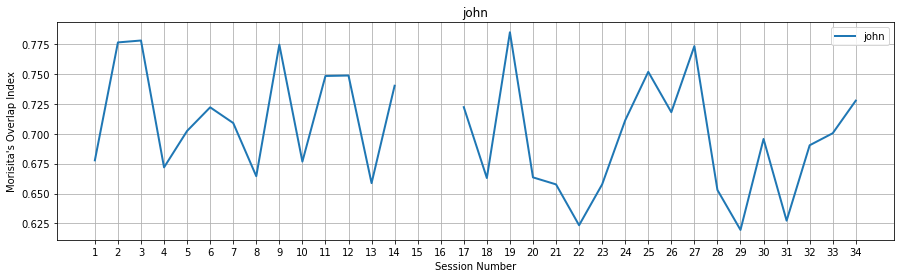

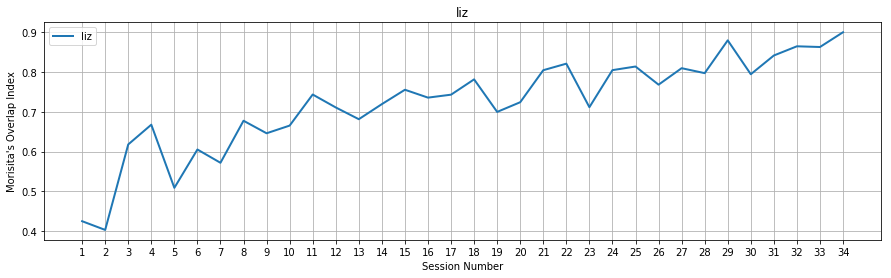

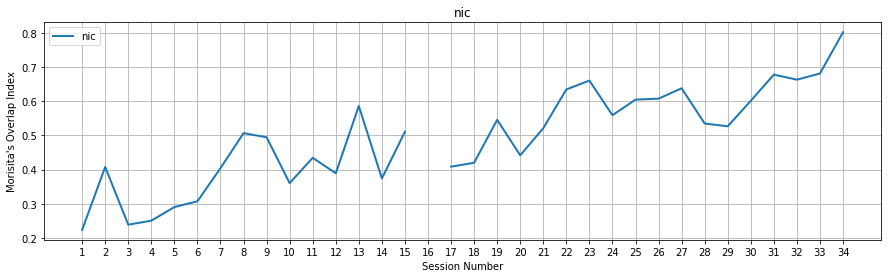

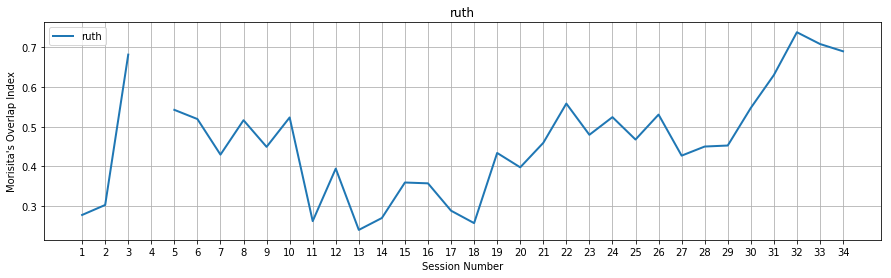

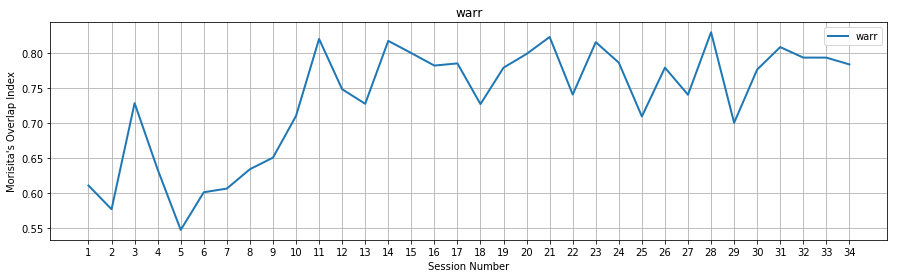

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


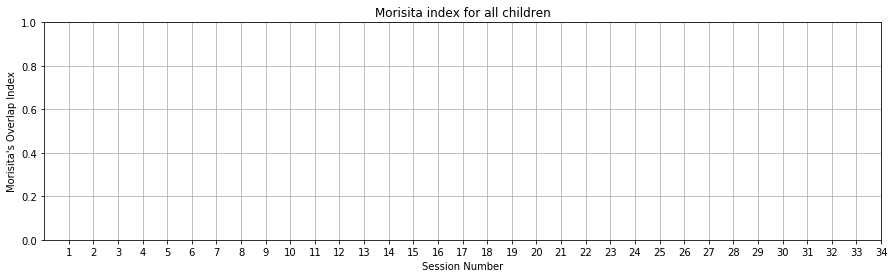

In [12]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(unigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-bigram'></a>
# Per-child plots of Morisita Bigrams

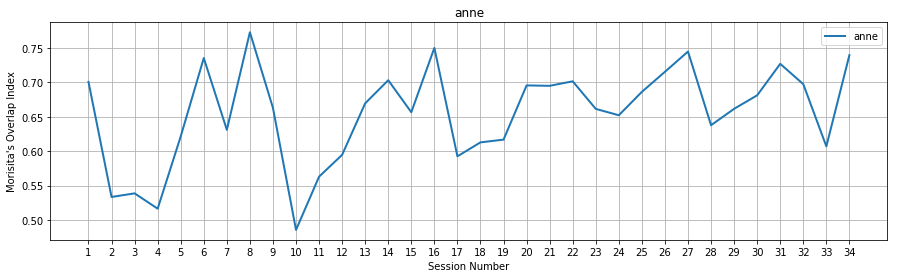

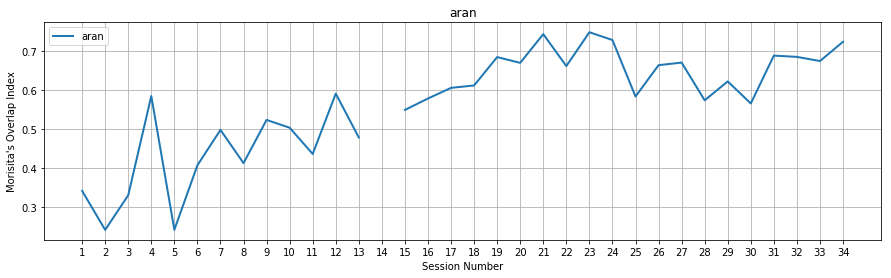

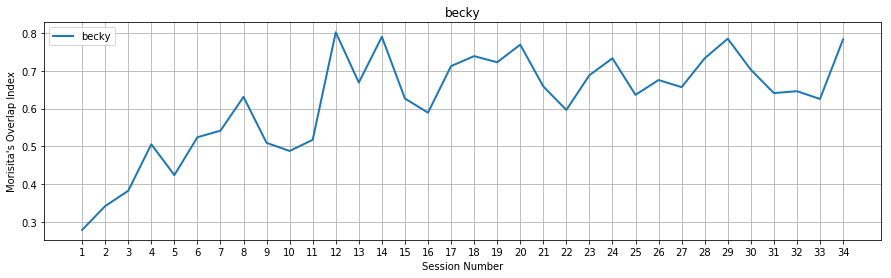

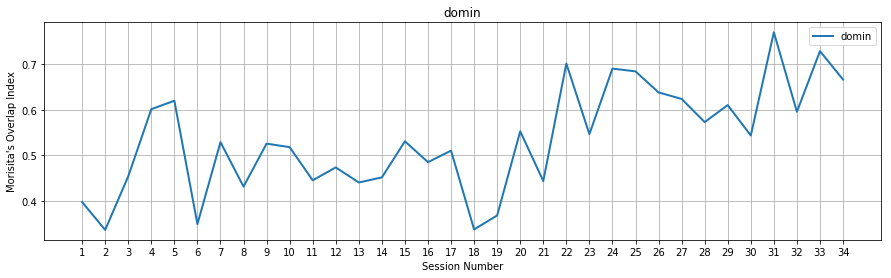

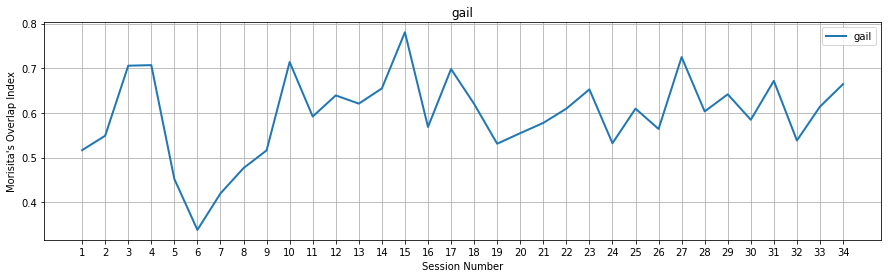

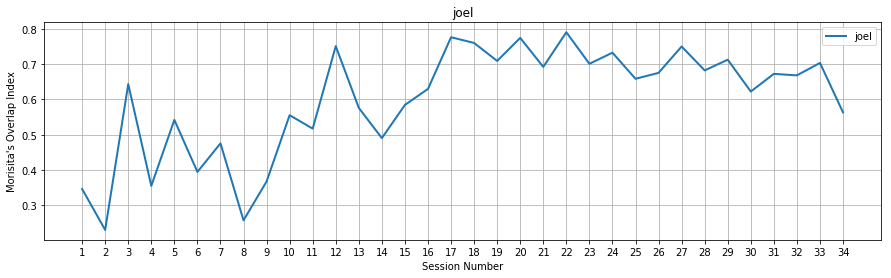

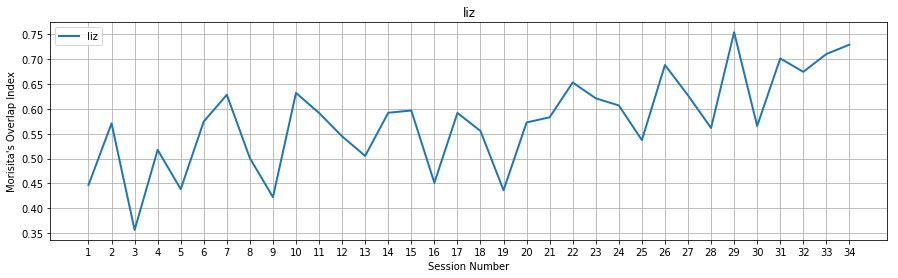

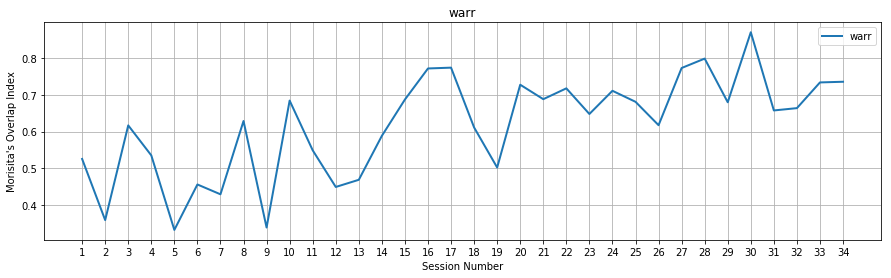

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


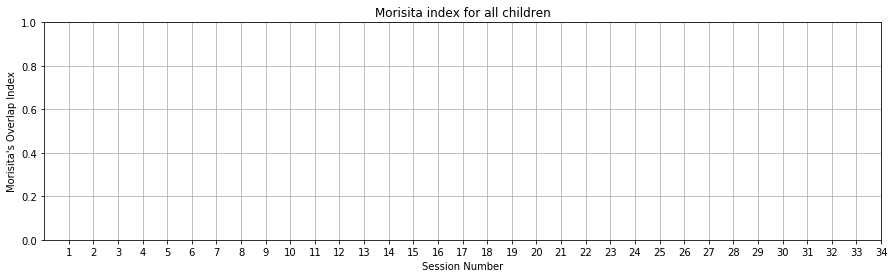

In [11]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(bigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')

<a id='per-child-trigram'></a>
# Per-child plots of Morisita Trigrams

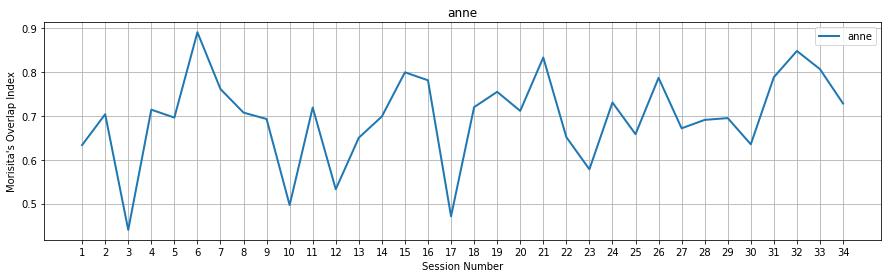

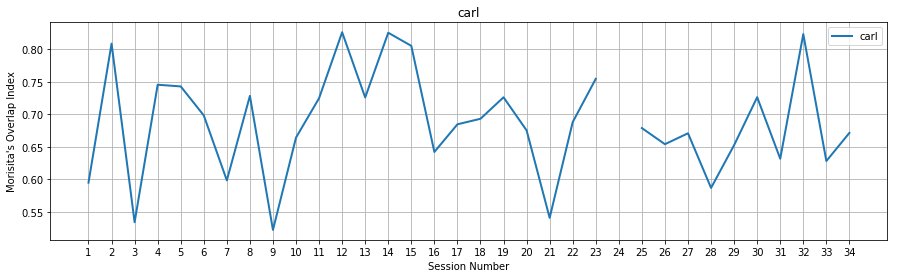

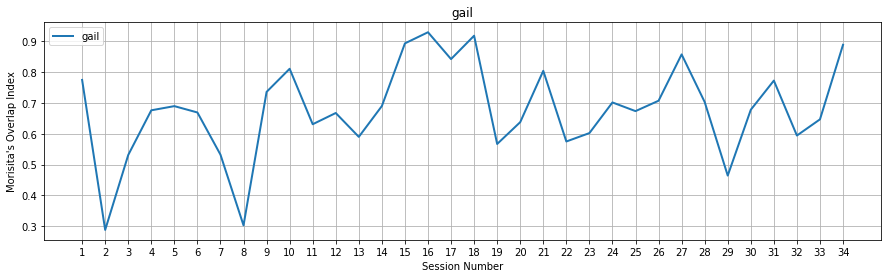

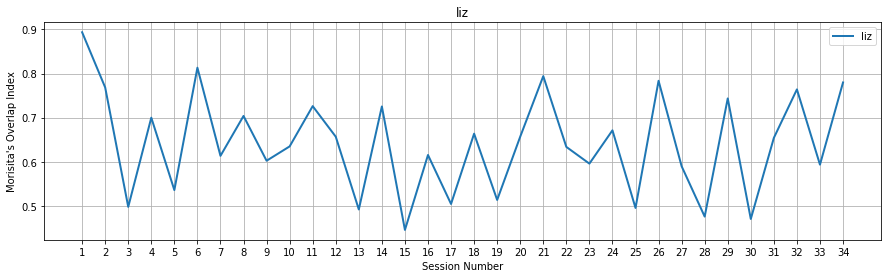

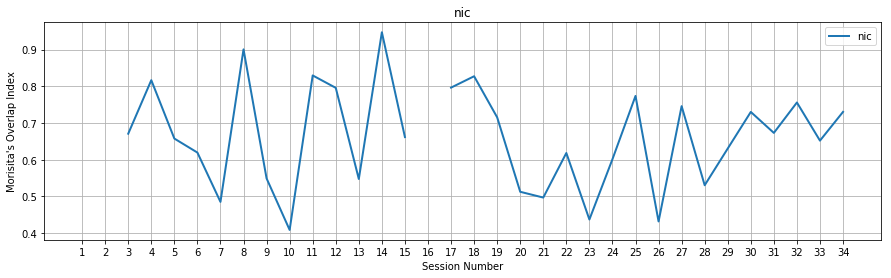

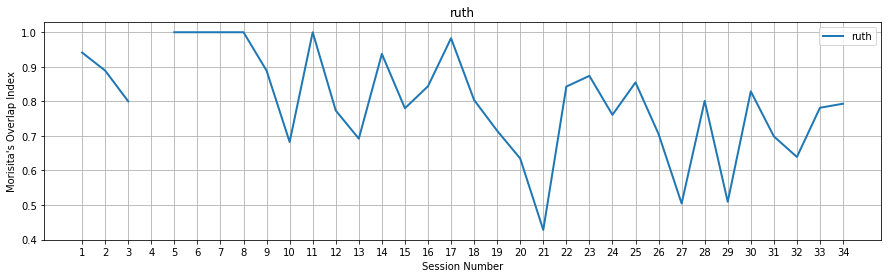

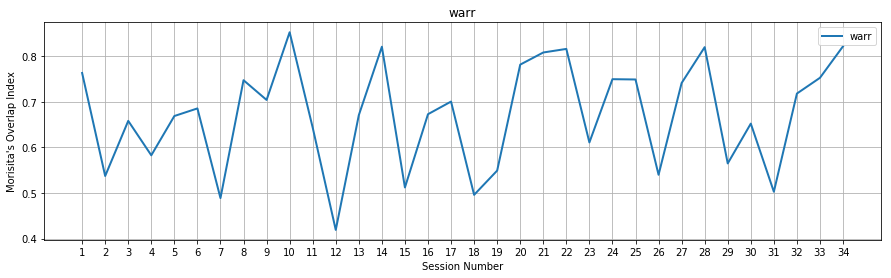

/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


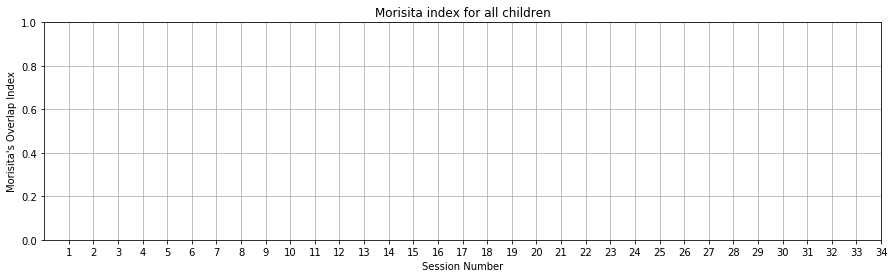

In [10]:
plt.rcParams['figure.figsize'] = 15, 4

children = unigrams.corpus.unique()

for index, child in enumerate(children):
    plot_child(trigrams, child, 2)
plt.legend();

per_session_plot('Morisita index for all children')